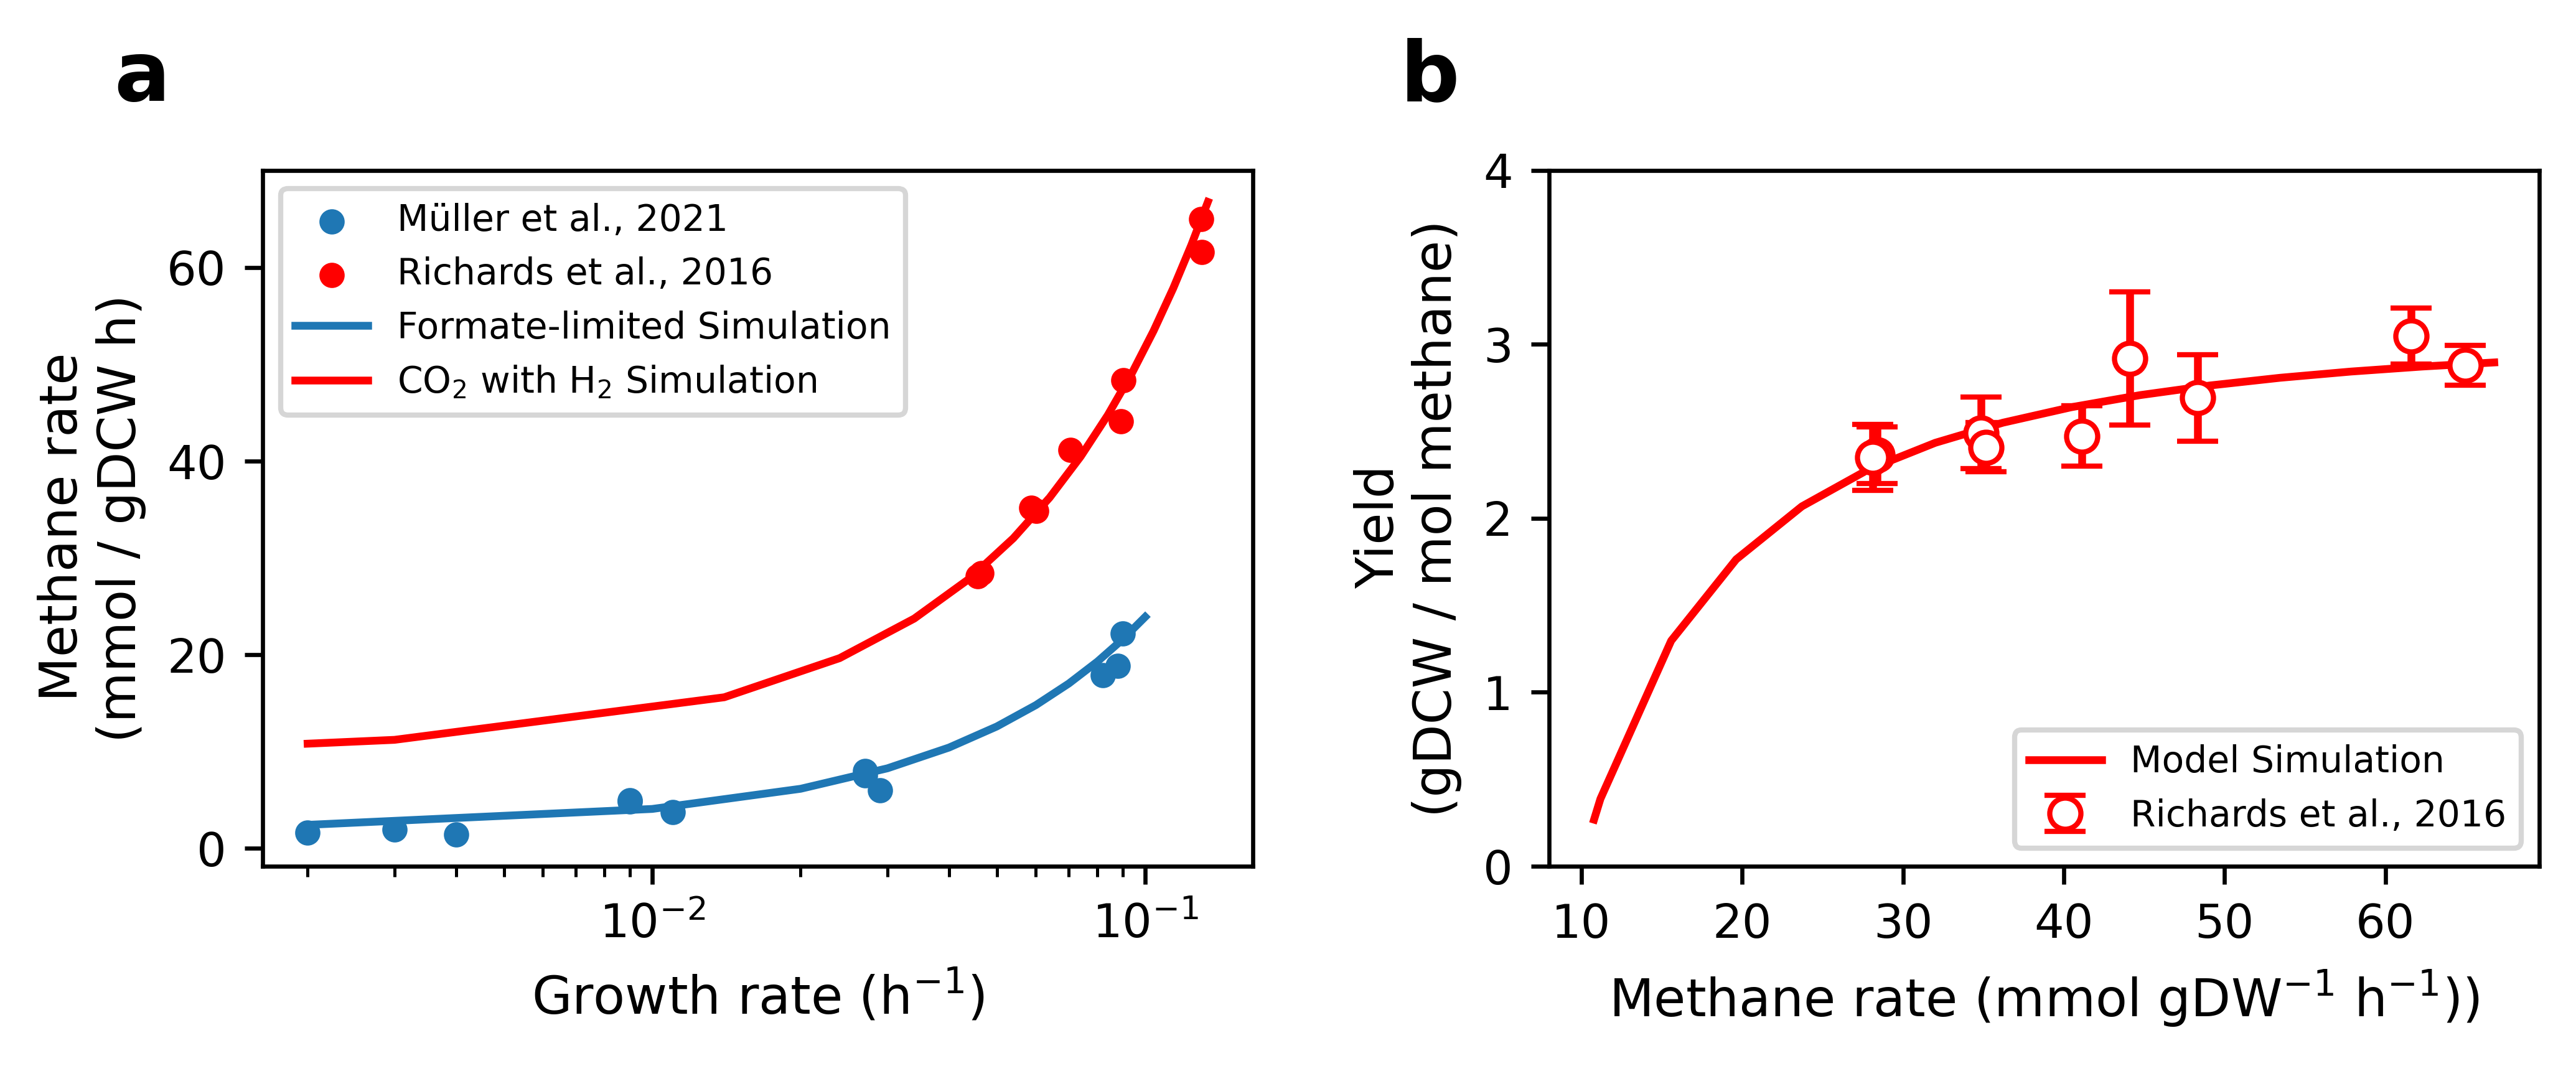

In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_co2_condition():
    methane_id = "R944"
    closed_reactions = ["R1165", "R895"]
    simulation = Simulation()
    simulation.set_parameter(model_file='pcMMP.xml',objective="R913",GAM=130,NGAM=5,excel_file='pcMMP.xlsx')
    simulation.close_reactions(closed_reactions)
    total_protein_mass=0.6
    up_co2_ratio=0.44*total_protein_mass
    simulation.set_constraint = [f"UP >= {up_co2_ratio}"]
    mu_list, methane_list = [], []
    mus = [0.002, 0.003, 0.014, 0.024, 0.034, 0.044, 0.054, 0.064, 0.074, 0.084, 0.094, 0.104, 0.114, 0.124, 0.134]
    for i, mu in enumerate(mus, start=1):
        simulation.file_path = f"output/lp_file_co2_{i}.lp"
        simulation.output_file = f"output/output_co2_{i}.lp"
        status = simulation.check_mu_optimal(mu)
        if status:
            fluxes = Fluxes(simulation.model, f"output/output_co2_{i}.lp")
            mu_list.append(mu)
            methane_list.append(fluxes.extract_reaction_flux(methane_id))

    return mu_list, methane_list

def plot_figures(mu_list_co2, methane_list_co2 ):
    plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize":9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7
})
    # Experimental Data from Richards et al., 2016
    full_growth_rates = np.array([0.0902, 0.0892, 0.0465, 0.0705, 0.0458, 0.0602, 0.0587, 0.1297, 0.1301])
    full_ch4_rates = np.array([48.34, 44.11, 28.40, 41.13, 28.12, 34.87, 35.17, 64.97, 61.58])
    # Experimental Data from Müller et al., 2021
    diluation_rate_formate_limited=np.array([0.003,0.002,0.004,0.009,0.009,0.011,0.027,0.027,0.029,0.090,0.082,0.088])
    exp_methane_Formate_limited=np.array([1.90,1.63,1.41,4.82,4.97,3.72,7.54,7.96,5.98,22.19,17.84,18.86])
   


    # from simulation of Formate-limited
    methane_formate_limited_simulated=[2.407812069,4.051747124,6.13500755,8.249441672,10.394709641,12.570471437,14.776386946,17.012116026,19.277318578,21.571654614,23.894784328]
    mu_formate_limited_simulated=[0.002, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

    # Compute yield
    yield_measured = (full_growth_rates / full_ch4_rates) * 1000 / np.log(2)
    simulated_growth_rates = np.array(mu_list_co2)
    simulated_ch4_rates = np.array(methane_list_co2)
    yield_simulation = (simulated_growth_rates / simulated_ch4_rates) * 1000 / np.log(2)
    # errors from Richards et al., 2016 
    errors = np.array([0.249, 0.383, 0.163, 0.175, 0.191, 0.207, 0.142, 0.115, 0.161])

    fig, axs = plt.subplots(1, 2, figsize=(7, 3), dpi=600)

    # Plot 1: Methane Formation
    axs[0].scatter(diluation_rate_formate_limited,exp_methane_Formate_limited , marker='o', label='Müller et al., 2021', s=15,color='#1f77b4' )
    axs[0].scatter(full_growth_rates,full_ch4_rates , marker='o', label='Richards et al., 2016',s=15, color='red')
    axs[0].plot(mu_formate_limited_simulated, methane_formate_limited_simulated, label='Formate-limited Simulation',color='#1f77b4' )
    axs[0].plot(mu_list_co2, methane_list_co2,  label=r'CO$_2$ with H$_2$ Simulation',color='red')
    axs[0].set_xscale('log')  
    axs[0].set_xlabel("Growth rate (h$^{-1}$)")
    axs[0].set_ylabel("Methane rate \n(mmol / gDCW h)")
    axs[0].legend(loc='upper left')

    axs[0].text(-0.15, 1.1, 'a', transform=axs[0].transAxes,fontsize=16, fontweight='bold')

    # Plot 2: Methane Yield
    axs[1].plot(simulated_ch4_rates, yield_simulation,label='Model Simulation',color='red')
    axs[1].errorbar(full_ch4_rates, yield_measured, yerr=errors, fmt='o', color='red', markersize=6, markerfacecolor='white', label='Richards et al., 2016', capsize=4)
    axs[1].set_xlabel("Methane rate (mmol gDW$^{-1}$ h$^{-1}$))")
    axs[1].set_ylabel("Yield \n(gDCW / mol methane)")
    axs[1].legend(loc='lower right')

    axs[1].text(-0.15, 1.1, 'b', transform=axs[1].transAxes,fontsize=16, fontweight='bold')
    axs[1].set_ylim(0, 4)

    plt.tight_layout()
    plt.savefig("Figures/methane_formation_and_yield.png")
    plt.show()
if __name__ == "__main__":
    
    mu_list, methane_list = simulate_co2_condition()
    plot_figures(mu_list, methane_list)